Mounted at /content/drive
Found 1292 images belonging to 17 classes.
Found 428 images belonging to 17 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 713s 17s/step - accuracy: 0.1760 - loss: 2.7563 - val_accuracy: 0.5023 - val_loss: 1.7786 - learning_rate: 1.0000e-04
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 547ms/step - accuracy: 0.5630 - loss: 1.5565 - val_accuracy: 0.8037 - val_loss: 1.0649 - learning_rate: 1.0000e-04
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 525ms/step - accuracy: 0.7462 - loss: 1.0204 - val_accuracy: 0.8505 - val_loss: 0.7351 - learning_rate: 1.0000e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 559ms/step - accuracy: 0.8281 - loss: 0.7254 - val_accuracy: 0.9136 - val_loss: 0.5248 - learning_rate: 1.0000e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 505ms/step - accuracy: 0.8786 - loss: 0.5346 - val_accuracy: 0.9299 - val_loss: 0.4079 - learning_rate: 1.0000e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 715ms/step - a

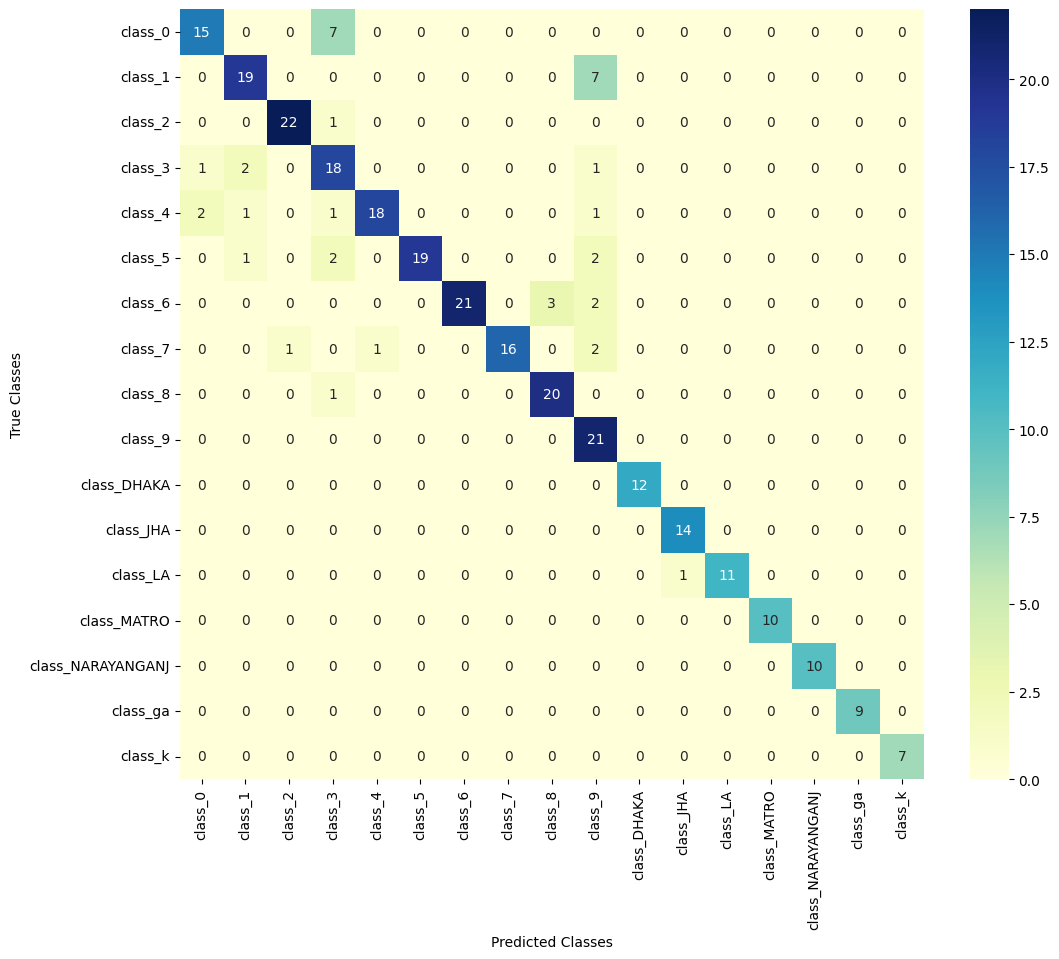

                   precision    recall  f1-score   support

          class_0       0.83      0.68      0.75        22
          class_1       0.83      0.73      0.78        26
          class_2       0.96      0.96      0.96        23
          class_3       0.60      0.82      0.69        22
          class_4       0.95      0.78      0.86        23
          class_5       1.00      0.79      0.88        24
          class_6       1.00      0.81      0.89        26
          class_7       1.00      0.80      0.89        20
          class_8       0.87      0.95      0.91        21
          class_9       0.58      1.00      0.74        21
      class_DHAKA       1.00      1.00      1.00        12
        class_JHA       0.93      1.00      0.97        14
         class_LA       1.00      0.92      0.96        12
      class_MATRO       1.00      1.00      1.00        10
class_NARAYANGANJ       1.00      1.00      1.00        10
         class_ga       1.00      1.00      1.00       

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import warnings
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
train_Path = '/content/drive/MyDrive/Dataset/training_data'
val_Path = '/content/drive/MyDrive/Dataset/val_data'
test_Path = '/content/drive/MyDrive/Dataset/testing_data'

# Set Image Size (Optimized for MobileNetV2)
IMAGE_SIZE = [224, 224]

# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
    train_Path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

val_set = val_datagen.flow_from_directory(
    val_Path,
    target_size=IMAGE_SIZE,
    batch_size=32,
    class_mode='categorical'
)

# Get number of classes
num_classes = training_set.num_classes

# Load Pretrained MobileNetV2
mobilenet = MobileNetV2(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

# Freeze Pretrained Layers
for layer in mobilenet.layers:
    layer.trainable = False

# Add Custom Layers
x = GlobalAveragePooling2D()(mobilenet.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)  # Use num_classes here

# Create Model
model = Model(inputs=mobilenet.input, outputs=output_layer)

# Compile Model
model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Callbacks to Prevent Overfitting
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

# Train the Model
history = model.fit(
    training_set,
    validation_data=val_set,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(val_set),
    callbacks=callbacks
)

# Evaluate on Test Dataset
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_Path,
    shuffle=False,
    batch_size=32,
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

# Get Predictions
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# Compute Confusion Matrix
cf_mtx = confusion_matrix(y_true, y_pred)
labels = {value: key for key, value in test_generator.class_indices.items()}

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
            cmap="YlGnBu", fmt="d", annot=True)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Print Classification Report
print(classification_report(y_true, y_pred, target_names=labels.values()))

# Final Model Evaluation
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
